# Description

Calculates the Bayesian credibility for the hypothesis that the event occurrence rate during a test B is higher than that during a test A, given the test duration and number of observed events for both test run A and B.

# Parameters

In [1]:
test_duration_A = 10
n_events_A = 5

test_duration_B = 10
n_events_B = 5

round_to_digits = 4

assert isinstance(test_duration_A, (int, float)) and test_duration_A >= 0
assert isinstance(test_duration_B, (int, float)) and test_duration_B >= 0
assert isinstance(n_events_A, int) and n_events_A >= 0
assert isinstance(n_events_B, int) and n_events_B >= 0
assert isinstance(round_to_digits, int) and round_to_digits >= 1

# Evaluation

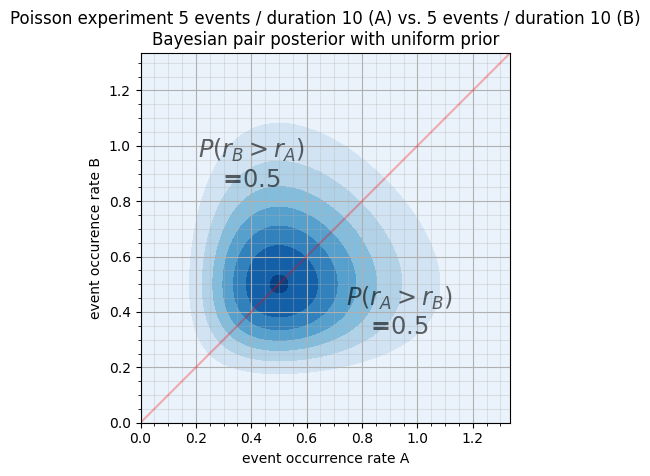

<class 'TypeError'>: cannot create mpf from array([1.5])

In [2]:
import matplotlib.pyplot as plt
import mpmath as mp
import numpy as np
from scipy import integrate

mp.mp.dps = 50 #use 50 decimal digits precision in mpmath calculations

def posterior_prob_poisson_p(r_event, test_duration, n_events, prior):
    return mp.power(mp.mpf(r_event*test_duration), n_events) / mp.fac(n_events) * mp.exp(-r_event*test_duration) * prior(r_event, test_duration)

posterior_prob_poisson_p_vectorized = np.vectorize(posterior_prob_poisson_p)

def posterior_pairs(r_A, test_duration_A, n_events_A, prior_A, r_B, test_duration_B, n_events_B, prior_B):
    return posterior_prob_poisson_p_vectorized(r_A, test_duration_A, n_events_A, prior=prior_A) * posterior_prob_poisson_p_vectorized(r_B, test_duration_B, n_events_B, prior=prior_B)

#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large test_duration
def integrate_posterior_prob_poisson_p(test_duration, n_events, prior, bounds):
    mean = (n_events+1) / test_duration
    std_dev = (n_events+1)**0.5 / test_duration
    prescale = 1/posterior_prob_poisson_p(mean, test_duration, n_events, prior)
    prior_prescaled = lambda r, duration: prior(r, duration) * prescale
    
    norm = 0
    if bounds[0] < mean-3*std_dev:
        norm += integrate.quad(posterior_prob_poisson_p, max(0, bounds[0]), min(mean-3*std_dev, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
    if bounds[0] < mean and bounds[1] >= mean-3*std_dev:
        norm += integrate.quad(posterior_prob_poisson_p, max(mean-3*std_dev, bounds[0]), min(mean, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
    if bounds[0] < mean+3*std_dev and bounds[1] >= mean:
        norm += integrate.quad(posterior_prob_poisson_p, max(mean, bounds[0]), min(mean+3*std_dev, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
    if bounds[0] < 1 and bounds[1] >= mean+3*std_dev:
        norm += integrate.quad(posterior_prob_poisson_p, max(mean+3*std_dev, bounds[0]), bounds[1], args=(test_duration, n_events, prior_prescaled))[0]
        
    return norm / prescale

#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large test_duration
def integrate_posterior_prob_poisson_p_quadrature(test_duration, n_events, prior, bounds):
    mean = (n_events+1) / test_duration
    std_dev = (n_events+1)**0.5 / test_duration
    prescale = 1/posterior_prob_poisson_p(mean, test_duration, n_events, prior)
    prior_prescaled = lambda r, duration: prior(r, duration) * prescale
    
    norm = 0
    if bounds[0] < mean-3*std_dev:
        norm += integrate.quadrature(posterior_prob_poisson_p, max(0, bounds[0]), min(mean-3*std_dev, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
    if bounds[0] < mean and bounds[1] >= mean-3*std_dev:
        norm += integrate.quadrature(posterior_prob_poisson_p, max(mean-3*std_dev, bounds[0]), min(mean, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
    if bounds[0] < mean+3*std_dev and bounds[1] >= mean:
        norm += integrate.quadrature(posterior_prob_poisson_p, max(mean, bounds[0]), min(mean+3*std_dev, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
    if bounds[0] < 1 and bounds[1] >= mean+3*std_dev:
        norm += integrate.quadrature(posterior_prob_poisson_p, max(mean+3*std_dev, bounds[0]), bounds[1], args=(test_duration, n_events, prior_prescaled))[0]
        
    return norm / prescale
    
#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large n_trial
def integrate_lower_triangle(test_duration_A, n_events_A, prior_A, test_duration_B, n_events_B, prior_B):
    mean_A = (n_events_A+1) / test_duration_A
    std_dev_A = (n_events_A+1)**0.5 / test_duration_A
    prescale_A = 1/posterior_prob_poisson_p(mean_A, test_duration_A, n_events_A, prior_A)
    prior_prescaled_A = lambda r, duration: prior_A(r, duration) * prescale_A
    
    mean_B = (n_events_B+1) / test_duration_B
    std_dev_B = (n_events_B+1)**0.5 / test_duration_B
    prescale_B = 1/posterior_prob_poisson_p(mean_B, test_duration_B, n_events_B, prior_B)
    prior_prescaled_B = lambda r, duration: prior_B(r, duration) * prescale_B

    bounds = [0, np.inf]

    f = lambda x: posterior_prob_poisson_p(x, test_duration_A, n_events_A, prior_prescaled_A) * integrate_posterior_prob_poisson_p_quadrature(test_duration_B, n_events_B, prior_prescaled_B, [0, x])
    
    norm = 0
    if bounds[0] < mean_A-3*std_dev_A:
        norm += integrate.quad(f, max(0, bounds[0]), min(mean_A-3*std_dev_A, bounds[1]))[0]
    if bounds[0] < mean_A and bounds[1] >= mean_A-3*std_dev_A:
        norm += integrate.quad(f, max(mean_A-3*std_dev_A, bounds[0]), min(mean_A, bounds[1]))[0]
    if bounds[0] < mean_A+3*std_dev_A and bounds[1] >= mean_A:
        norm += integrate.quad(f, max(mean_A, bounds[0]), min(mean_A+3*std_dev_A, bounds[1]))[0]
    if bounds[0] < 1 and bounds[1] >= mean_A+3*std_dev_A:
        norm += integrate.quad(f, max(mean_A+3*std_dev_A, bounds[0]), min(1, bounds[1]))[0]
        
    return norm / prescale_A / prescale_B

r_plotmax_A = (n_events_A+1)/test_duration_A + 3*(n_events_A+1)**0.5/test_duration_A #mean+5*std_dev
r_plotmax_B = (n_events_B+1)/test_duration_B + 3*(n_events_B+1)**0.5/test_duration_B #mean+5*std_dev
r_maxplot = max(r_plotmax_A, r_plotmax_B)

r_A = np.linspace(0, r_maxplot, 101)
r_B = np.linspace(0, r_maxplot, 101)

prior_A = lambda r, duration: 1
prior_B = lambda r, duration: 1

norm_A = integrate_posterior_prob_poisson_p(test_duration_A, n_events_A, prior_A, [0, 1])
norm_B = integrate_posterior_prob_poisson_p(test_duration_B, n_events_B, prior_B, [0, 1])

X, Y = np.meshgrid(r_A, r_B)
posterior_probs = posterior_pairs(X, test_duration_A, n_events_A, prior_A, Y, test_duration_B, n_events_B, prior_B) / (norm_A * norm_B)

plt.contourf(X, Y, posterior_probs, cmap='Blues')
plt.axline([0,0], [1,1], color='red', alpha=0.3)

plt.gca().set_title('Poisson experiment {} events / duration {} (A) vs. {} events / duration {} (B)\nBayesian pair posterior with uniform prior'.format(n_events_A, test_duration_A, n_events_B, test_duration_B))
plt.gca().set_xlabel('event occurrence rate A')
plt.gca().set_ylabel('event occurence rate B')
plt.gca().tick_params(axis='x', which='minor', bottom=True)
plt.gca().minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3);
plt.gca().set_aspect('equal')

plt.text(r_maxplot*0.3, r_maxplot*0.7, '$P(r_B > r_A)$\n=${}$'.format(0.5), horizontalalignment='center', verticalalignment='center', fontsize='xx-large', fontweight='bold', alpha=0.6)
plt.text(r_maxplot*0.7, r_maxplot*0.3, '$P(r_A > r_B)$\n=${}$'.format(0.5), horizontalalignment='center', verticalalignment='center', fontsize='xx-large', fontweight='bold', alpha=0.6);

P_A_better_B = integrate_lower_triangle(test_duration_A, n_events_A, prior_A, test_duration_B, n_events_B, prior_B) / (norm_A * norm_B)
P_A_better_B_rounded = mp.nstr(mp.mpf(P_A_better_B), round_to_digits)
P_B_better_A_rounded = mp.nstr(1-mp.mpf(P_A_better_B), round_to_digits)